# Recycling Labs Framework From Libs

In [8]:
from src.preprocessing import clean_func, spacy_preprocess_reviews
from src.sts import STSAnalyzer
from src.models import BaselineModel
import numpy as np
from nltk.metrics import jaccard_distance
import os
import pandas as pd
# IMport partial
from functools import partial
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk import ngrams
brown_ic = wordnet_ic.ic('ic-brown.dat')
from nltk import download
import nltk

download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')

import spacy
nlp = spacy.load("en_core_web_sm")
from spacy_wordnet.wordnet_annotator import WordnetAnnotator 
# Load a spaCy model (supported languages are "es" and "en") 
nlp = spacy.load('en_core_web_sm')
# spaCy 3.x
nlp.add_pipe("spacy_wordnet", after='tagger')

import textdistance

prep_func = partial(spacy_preprocess_reviews, clean_func=clean_func, out_set=False)
INPUT_FOLDER = "input"
TRAIN_PATH = os.path.join(INPUT_FOLDER, "train")
TEST_PATH = os.path.join(INPUT_FOLDER, "test")
LS_FILES_TRAIN = ["MSRpar", "MSRvid", "SMTeuroparl"]
LS_FILES_TEST = ["MSRpar", "MSRvid", "SMTeuroparl", "surprise.SMTnews", "surprise.OnWN"]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/alberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alberto/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/alberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [112]:
def dice_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)
    try:
        return 2*len(x_n_y) / (len(x) + len(y))
    except ZeroDivisionError:
        return 0

def overlap_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)
    try:
        return len(x_n_y) / min(len(x), len(y))
    except ZeroDivisionError:
        return 0

def cosine_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)

    if len(x_n_y) == 0:
        return 0
    
    try:
        return len(x_n_y) / np.sqrt(len(x)*len(y))
    except ZeroDivisionError:
        return 0

def jaccard_sim(x, y):
    '''
    Get the Jaccard similarity between two sets
    '''
    x = set(x)
    y = set(y)
    try:
        return 1 - jaccard_distance(x, y)
    except ZeroDivisionError:
        return 0


def get_similarities(X, d_sim=None):
    '''
    Get the similarities between two sentences
    '''
    df_sim = pd.DataFrame()
    if d_sim is None:
        d_sim = {"jaccard": jaccard_sim, "dice": dice_sim, 
                  "overlap": overlap_sim, "cosine": cosine_sim}
        
    for name, sim in d_sim.items():
        df_sim[name] = X.apply(lambda x: sim(x["sent1"], x["sent2"]), axis=1)
        
    return df_sim

def calculate_idf(term, documents):
    document_frequency = sum(1 for document in documents if term in document)
    if document_frequency == 0:
        return 0.0
    else:
        return np.log(len(documents) / document_frequency)
    
def compare_synsets(ls_ls_syns1, ls_ls_syns2, documents=None, similarity=get_wup_similarity, idf=True):

    d_out = {}
    for w, ls_syns1 in ls_ls_syns1:
        d_out[w] = []
        for _, ls_syns2 in ls_ls_syns2:
            for syn1 in ls_syns1:
                for syn2 in ls_syns2:
                    out = similarity(syn1, syn2) if syn1.pos() == syn2.pos() else 0
                    out = 0 if out is None else out
                    d_out[w].append(out)
                    # print(syn1, syn2, out)
        
        if d_out[w] != []:
            if idf:
                d_out[w] = calculate_idf(w, documents) * np.max(d_out[w])
            else:
                d_out[w] = np.max(d_out[w])
        else:
            d_out[w] = 0

    return d_out

def get_sem_similarities(X, d_sim=None, idf=True, documents=None):
    '''
    Get the similarities between two sentences
    '''
    if d_sim is None:
        d_sim = {"wup": get_wup_similarity, "path": get_path_similarity, 
                  "lch": get_lch_similarity, "lin": get_lin_similarity}

    df_sim = pd.DataFrame()
    for name, sim in d_sim.items():
        if idf:
            sim_fw = X.apply(lambda x: sum(compare_synsets(x.iloc[0], x.iloc[1], documents, similarity=sim).values()), axis=1)
            sim_bw = X.apply(lambda x: sum(compare_synsets(x.iloc[1], x.iloc[0], documents, similarity=sim).values()), axis=1)
        else:
            sim_fw = X.apply(lambda x: sum(compare_synsets(x.iloc[0], x.iloc[1], idf=idf, similarity=sim).values()), axis=1)
            sim_bw = X.apply(lambda x: sum(compare_synsets(x.iloc[1], x.iloc[0], idf=idf, similarity=sim).values()), axis=1)
        
        df_sim[name] = (sim_fw + sim_bw) / 2

    return df_sim

def get_path_similarity(syn1, syn2):
    return syn1.path_similarity(syn2)

def get_lch_similarity(syn1, syn2):
    try:
        return syn1.lch_similarity(syn2)
    except:
        return None
    
def get_wup_similarity(syn1, syn2):
    try:
        return syn1.wup_similarity(syn2)
    except:
        return None
    
def get_lin_similarity(syn1, syn2):
    try:
        return syn1.lin_similarity(syn2, brown_ic)
    except:
        return None
    
def longest_common_substring(str1, str2):
    return textdistance.lcsstr.similarity(str1, str2)

def longest_common_subsequence(str1, str2):
    return textdistance.lcsseq.similarity(str1, str2)

def greedy_string_tiling(str1, str2):
    return textdistance.ratcliff_obershelp.similarity(str1, str2)

def jaro_similarity(str1, str2):
    return textdistance.jaro.similarity(str1, str2)  # Use jellyfish for Jaro similarity

def jaro_winkler_similarity(str1, str2):
    return textdistance.jaro_winkler.similarity(str1, str2)

def monge_elkan_similarity(str1, str2):
    return textdistance.monge_elkan.similarity(str1, str2)

def levenshtein_distance(str1, str2):
    return textdistance.levenshtein.similarity(str1, str2)


def get_textdistance_similarities(X, d_sim=None):
    '''
    Get the similarities between two sentences
    '''
    if d_sim is None:
        d_sim = {"lcstr": longest_common_substring, "lcseq": longest_common_subsequence, 
                  "gst": greedy_string_tiling, "jaro": jaro_similarity, 
                  "jaro_w": jaro_winkler_similarity, "monge": monge_elkan_similarity, 
                  "levenshtein": levenshtein_distance}

    df_sim = pd.DataFrame()
    for name, sim in d_sim.items():
        df_sim[name] = X.apply(lambda x: sim(x["sent1"], x["sent2"]), axis=1)

    return df_sim

def get_word_ngrams(text, n, tokenize=True):
    if tokenize:
        words = nltk.word_tokenize(text)
    else:
        words = text
    return list(ngrams(words, n))

def get_ngrams_similarity(x, y, sim, n=2, tokenize=True):
    ngrams1 = get_word_ngrams(x, n, tokenize=tokenize)
    ngrams2 = get_word_ngrams(y, n, tokenize=tokenize)
    return sim(ngrams1, ngrams2)

def get_ngrams_similarities(X, d_sim=None, nmax=5, tokenize=True):
    '''
    Get the similarities between two sentences
    '''
    if d_sim is None:
        d_sim = {"jaccard": jaccard_sim, "dice": dice_sim, 
                  "overlap": overlap_sim, "cosine": cosine_sim}

    df_sim = pd.DataFrame()
    for n in range(1, nmax+1):
        for name, sim in d_sim.items():
            df_sim[name + f"_n_{n}"] = X.apply(lambda x: get_ngrams_similarity(x["sent1"], x["sent2"], sim, n=n, tokenize=tokenize), axis=1)
        
    return df_sim

## STS Analyzer

In [3]:
import pandas as pd
sts = STSAnalyzer(preprocess_fun=prep_func, model=BaselineModel(),
                  ls_files=LS_FILES_TRAIN, input_path=TRAIN_PATH)
df = sts.load_data()

## Get Tokenization

In [4]:
# 0. Preprocess for similarity
df_prep = df.copy()
df_prep["sent1"] = df_prep["sent1"].apply(lambda x: prep_func(x, out_set=True))
df_prep["sent2"] = df_prep["sent2"].apply(lambda x: prep_func(x, out_set=True))
df_prep

,sent1,sent2,gs,file
0,"{individual, say, door, open, team, source, cl...","{say, door, open, source, close, keep, sale, d...",4.00,MSRpar
1,"{micron, year, profit, quarterly, declare}","{micron, manufacturer, profit, year, dram, qua...",3.75,MSRpar
2,"{return, democrats, republican, fine, force, e...","{include, say, senate, return, democrats, back...",2.80,MSRpar
3,"{american, conservative, say, create, anglican...","{american, conservative, say, create, anglican...",3.40,MSRpar
4,"{end, composite, load, high, month, 1595.91, t...","{1.2_%, composite, ixic, point, index, technol...",2.40,MSRpar
...,...,...,...,...
2229,"{include, decide, need, item, quickly, agenda,...","{urgent, decide, item, agenda}",5.00,SMTeuroparl
2230,"{improvement, wish, good, start, believe, hone...","{think, good, start, well, want, honestly, act...",4.80,SMTeuroparl
2231,"{parliament, amendment, accept, oral}","{parliament, amendment, accept, oral}",5.00,SMTeuroparl
2232,"{apply, party, standard, reservation, communit...","{party, standard, reservation, community, mutu...",4.80,SMTeuroparl


In [137]:
df_prep_ls = df.copy()
df_prep_ls["sent1"] = df_prep_ls["sent1"].apply(lambda x: prep_func(x, out_set=False))
df_prep_ls["sent2"] = df_prep_ls["sent2"].apply(lambda x: prep_func(x, out_set=False))
df_prep_ls

,sent1,sent2,gs,file
0,"[source, close, sale, say, vivendi, keep, door...","[source, close, sale, say, vivendi, keep, door...",4.00,MSRpar
1,"[micron, declare, quarterly, profit, year]","[micron, number, mark, quarterly, profit, year...",3.75,MSRpar
2,"[fine, fail, republican, effort, force, entice...","[perry, say, back, senate, effort, include, fi...",2.80,MSRpar
3,"[american, anglican, council, represent, episc...","[american, anglican, council, represent, episc...",3.40,MSRpar
4,"[tech, load, nasdaq, composite, rise, 20.96, p...","[technology, lace, nasdaq, composite, index, i...",2.40,MSRpar
...,...,...,...,...
2229,"[action, need, quickly, decide, include, item,...","[urgent, decide, item, agenda]",5.00,SMTeuroparl
2230,"[wish, improvement, honestly, believe, good, s...","[actually, want, well, think, honestly, good, ...",4.80,SMTeuroparl
2231,"[parliament, accept, oral, amendment]","[parliament, accept, oral, amendment]",5.00,SMTeuroparl
2232,"[party, reservation, community, law, apply, sa...","[party, reservation, regulation, sale, consump...",4.80,SMTeuroparl


# Clean text

In [61]:
df_clean = df.copy()
df_clean["sent1"] = df_clean["sent1"].apply(lambda x: clean_func(x))
df_clean["sent2"] = df_clean["sent2"].apply(lambda x: clean_func(x))
df_clean

,sent1,sent2,gs,file
0,but other sources close to the sale said viven...,but other sources close to the sale said viven...,4.00,MSRpar
1,micron has declared its first quarterly profit...,micron numbers also marked the first quarterly...,3.75,MSRpar
2,the fines are part of failed republican effort...,"perry said he backs the senate efforts, includ...",2.80,MSRpar
3,"the american anglican council, which represent...","the american anglican council, which represent...",3.40,MSRpar
4,the tech-loaded nasdaq composite rose 20.96 po...,the technology-laced nasdaq composite index ix...,2.40,MSRpar
...,...,...,...,...
2229,"action is needed quickly, which is why we deci...",it is urgent and that is why we have decided t...,5.00,SMTeuroparl
2230,one could indeed wish for more and for improve...,"we can actually want more and better, but i th...",4.80,SMTeuroparl
2231,(parliament accepted the oral amendment),(parliament accepted the oral amendment),5.00,SMTeuroparl
2232,- my party has serious reservations about comm...,my party serious reservations about the regula...,4.80,SMTeuroparl


## Get Synsets

In [6]:
# Calculate Synsets
df_synsets = df[['sent1', 'sent2']].copy()
df_synsets = df_synsets.map(lambda x: [(token.text, token._.wordnet.synsets()) for token in nlp(x)
                    if not token.is_stop and not token.is_punct 
                    and not token.is_space])

df_synsets.head()

,sent1,sent2
0,"[(sources, [Synset('beginning.n.04'), Synset('...","[(sources, [Synset('beginning.n.04'), Synset('..."
1,"[(Micron, [Synset('micron.n.01')]), (declared,...","[(Micron, [Synset('micron.n.01')]), (numbers, ..."
2,"[(fines, [Synset('fine.n.01')]), (failed, [Syn...","[(Perry, [Synset('perry.n.01'), Synset('perry...."
3,"[(American, [Synset('american.n.01'), Synset('...","[(American, [Synset('american.n.01'), Synset('..."
4,"[(tech, [Synset('technical_school.n.01')]), (l...","[(technology, [Synset('technology.n.01'), Syns..."


# Create Features

In [161]:
df_features = pd.DataFrame()

## String Similarity

In [162]:
df_textdistance = get_textdistance_similarities(df_clean)

if len(df_features.columns.intersection(df_textdistance.columns)) == 0:
    df_features = pd.concat([df_features, df_textdistance], axis=1)

## N-Grams

In [163]:
df_ngram_sim = get_ngrams_similarities(df_clean)

if len(df_features.columns.intersection(df_ngram_sim.columns)) == 0:
    df_features = pd.concat([df_features, df_ngram_sim], axis=1)

df_ngram_sim_spacy = get_ngrams_similarities(df_prep_ls, tokenize=False)
df_ngram_sim_spacy.columns = [col + "_spacy" for col in df_ngram_sim_spacy.columns]

if len(df_features.columns.intersection(df_ngram_sim_spacy.columns)) == 0:
    df_features = pd.concat([df_features, df_ngram_sim_spacy], axis=1)

## Semantic Similarity

In [167]:
documents = df_prep["sent1"].tolist() + df_prep["sent2"].tolist()

df_sem_sim = get_sem_similarities(df_synsets, idf=True, documents=documents)
df_sem_sim_not_idf = get_sem_similarities(df_synsets, idf=False)
df_sem_sim.columns = [col + "_idf" for col in df_sem_sim.columns]

if len(df_sem_sim.columns.intersection(df_features.columns)) == 0:
    df_features = pd.concat([df_features, df_sem_sim], axis=1)

if len(df_sem_sim_not_idf.columns.intersection(df_sem_sim_not_idf.columns)) == 0:
    df_features = pd.concat([df_features, df_sem_sim_not_idf], axis=1)

In [169]:
df_features

,lcstr,lcseq,gst,jaro,jaro_w,monge,levenshtein,jaccard_n_1,dice_n_1,overlap_n_1,...,overlap_n_4_spacy,cosine_n_4_spacy,jaccard_n_5_spacy,dice_n_5_spacy,overlap_n_5_spacy,cosine_n_5_spacy,wup_idf,path_idf,lch_idf,lin_idf
0,75,105,0.738007,0.865225,0.919135,0.006369,104,0.548387,0.708333,0.772727,...,0.857143,0.654654,0.416667,0.588235,0.833333,0.615457,23.196118,20.990641,48.063633,12.488635
1,24,53,0.670886,0.738972,0.843383,0.015873,50,0.444444,0.615385,0.727273,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.259490,13.458484,25.830211,6.830353
2,27,56,0.464865,0.782203,0.782203,0.010989,39,0.363636,0.533333,0.533333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.899164,10.503088,38.100192,13.083557
3,129,133,0.833856,0.901976,0.941186,0.007407,133,0.655172,0.791667,0.950000,...,0.888889,0.739600,0.538462,0.700000,0.875000,0.714435,28.307168,25.846529,78.615259,21.092590
4,20,54,0.507614,0.696501,0.696501,0.009342,44,0.250000,0.400000,0.437500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.805330,10.339157,49.972170,12.602037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,25,57,0.708075,0.724605,0.724605,0.011073,51,0.478261,0.647059,0.647059,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.682726,11.342125,43.193160,10.660924
2230,14,56,0.564103,0.690038,0.690038,0.008900,46,0.413793,0.585366,0.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.528130,22.035643,49.198293,15.084808
2231,40,40,1.000000,1.000000,1.000000,2.000000,40,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.174603,11.174603,18.451625,5.072492
2232,48,129,0.709859,0.770009,0.770009,0.005952,107,0.566667,0.723404,0.739130,...,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,38.752313,30.728794,114.139534,30.460916


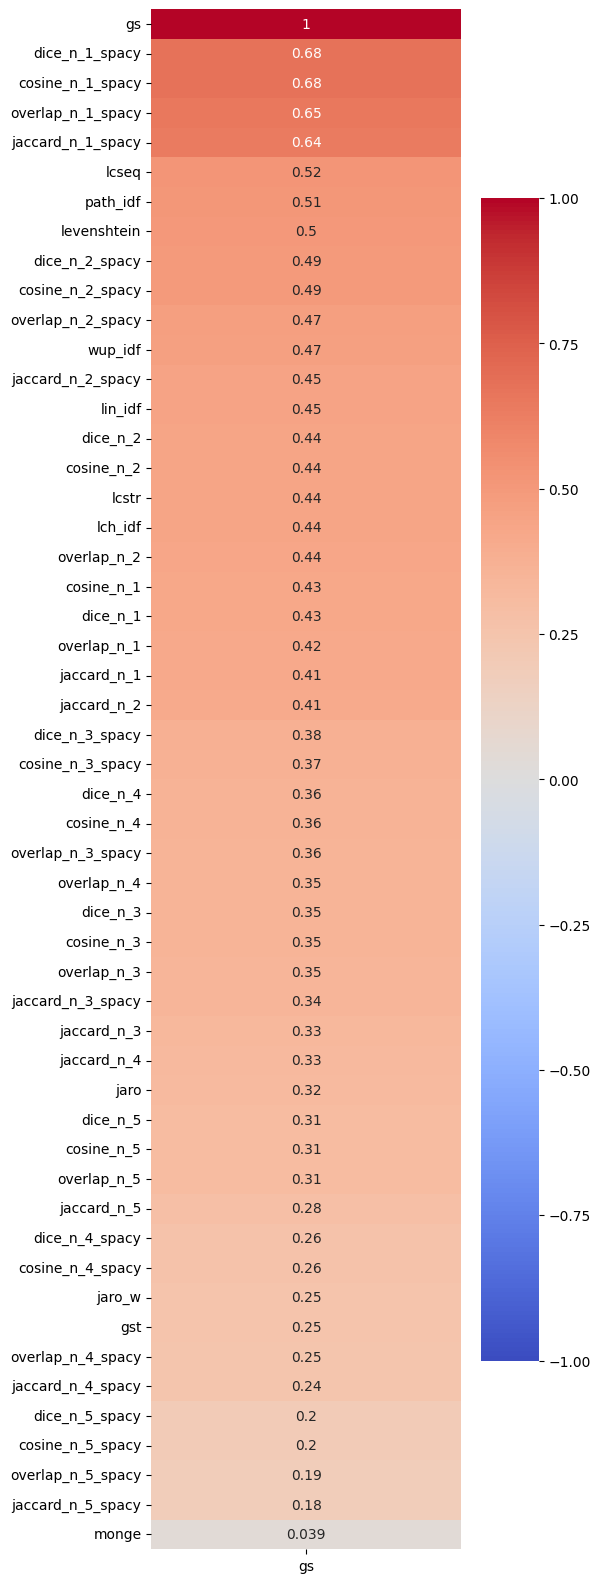

In [170]:

df_corr = pd.concat([df_features, df_prep["gs"]], axis=1)

# Plot heatmap of correlations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_corr = pd.DataFrame(sc.fit_transform(df_corr), columns=df_corr.columns)
plt.figure(figsize=(5, 20))
sns.heatmap(df_corr.corr()[["gs"]].sort_values(by="gs", ascending=False), annot=True, cmap="coolwarm", label="big",
            vmin=-1, vmax=1)
plt.show()


## Get all synsets

In [177]:
df_synsets = df_sen.map(lambda x: [(token.text, token._.wordnet.synsets()) for token in nlp(x)
                                                                  if not token.is_stop and not token.is_punct 
                                                                  and not token.is_space])

In [178]:
df_synsets.head(3)

,sent1,sent2
1034,"[(person, [Synset('person.n.01'), Synset('pers...","[(man, [Synset('man.n.01'), Synset('serviceman..."
426,"[(real, [Synset('very.r.01')]), (excited, [Syn...","[(excited, [Synset('aroused.s.06'), Synset('ex..."
482,"[(U.S., [Synset('united_states_government.n.01...","[(Bush, [Synset('shrub.n.01'), Synset('bush.n...."


In [136]:



calculate_idf("scallop", documents)

8.404696160189092

In [68]:
df_sen

,sent1,sent2
1034,A person is walking down a stone path.,A man is walking down a sidewalk.
426,"""I'm real excited to be a Cleveland Cavalier,""...","""I'm really excited about going to Cleveland,""..."
482,U.S. and European leaders pledged on Wednesday...,"Bush said U.S. and European Union leaders, at ..."
755,A person is peeling shrimp.,A person is preparing shrimp.
445,"Several shots rang out in the darkness, but on...","Several shots rang out Wednesday night, but no..."
...,...,...
1638,It is gratifying that Parliament has succeeded...,We must welcome the fact that Parliament has m...
1095,A band is performing on a stage.,A band is playing and singing on a stage.
1130,A man is riding on a horse.,A woman is riding an elephant.
1294,A man is slicing a bun.,A man is breaking pots.


In [128]:


ls_ls_syns1 = df_synsets["sent1"].iloc[100]
ls_ls_syns2 = df_synsets["sent2"].iloc[100]
print(len(ls_ls_syns1), ls_ls_syns1)
print(len(ls_ls_syns2), ls_ls_syns2)

compare_synsets(ls_ls_syns1, ls_ls_syns2)

12 [[Synset('company.n.01'), Synset('company.n.02'), Synset('company.n.03'), Synset('company.n.04'), Synset('caller.n.01'), Synset('company.n.06'), Synset('party.n.03'), Synset('ship's_company.n.01'), Synset('company.n.09')], [Synset('post.v.01'), Synset('post.v.02'), Synset('post.v.03'), Synset('station.v.01'), Synset('post.v.05'), Synset('post.v.06'), Synset('post.v.07'), Synset('post.v.08'), Synset('stake.v.03'), Synset('post.v.10'), Synset('mail.v.02'), Synset('post.v.12')], [Synset('net_income.n.01'), Synset('profit.n.02')], [], [], [Synset('million.n.01'), Synset('million.n.02'), Synset('million.s.01')], [Synset('twenty-two.n.01'), Synset('twenty-two.s.01')], [Synset('cent.n.01'), Synset('penny.n.02')], [Synset('share.n.01'), Synset('share.n.02'), Synset('parcel.n.02'), Synset('contribution.n.01'), Synset('plowshare.n.01')], [Synset('year.n.01'), Synset('year.n.02'), Synset('year.n.03'), Synset('class.n.06')], [Synset('ago.s.01')], [Synset('time_period.n.01'), Synset('period.n.02

{0: 1.0,
 1: 0.3333333333333333,
 2: 0.625,
 3: 0,
 4: 0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 0.9090909090909091}

In [127]:
compare_synsets(ls_ls_syns2, ls_ls_syns1)

{0: 1.0,
 1: 1.0,
 2: 0.9090909090909091,
 3: 1.0,
 4: 0.3333333333333333,
 5: 0,
 6: 0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0}

In [96]:
len(ls_ls_syns2)

3

In [145]:
from itertools import product


,sent1,sent2,sim_fw,sim_bw,sim
1034,"[(person, [Synset('person.n.01'), Synset('pers...","[(man, [Synset('man.n.01'), Synset('serviceman...",14.626572,8.286101,11.456336
426,"[(real, [Synset('very.r.01')]), (excited, [Syn...","[(excited, [Synset('aroused.s.06'), Synset('ex...",8.404696,8.404696,8.404696
482,"[(U.S., [Synset('united_states_government.n.01...","[(Bush, [Synset('shrub.n.01'), Synset('bush.n....",12.476657,12.303694,12.390176
755,"[(person, [Synset('person.n.01'), Synset('pers...","[(person, [Synset('person.n.01'), Synset('pers...",9.525944,9.525944,9.525944
445,"[(shots, [Synset('shooting.n.01'), Synset('sho...","[(shots, [Synset('shooting.n.01'), Synset('sho...",17.827665,4.824593,11.326129
...,...,...,...,...,...
1638,"[(gratifying, [Synset('satisfy.v.02'), Synset(...","[(welcome, [Synset('welcome.v.01'), Synset('we...",16.920353,26.064399,21.492376
1095,"[(band, [Synset('set.n.05'), Synset('band.n.02...","[(band, [Synset('set.n.05'), Synset('band.n.02...",11.703447,14.233549,12.968498
1130,"[(man, [Synset('man.n.01'), Synset('serviceman...","[(woman, [Synset('woman.n.01'), Synset('woman....",5.399964,7.389398,6.394681
1294,"[(man, [Synset('man.n.01'), Synset('serviceman...","[(man, [Synset('man.n.01'), Synset('serviceman...",5.350474,1.923119,3.636797


In [168]:
X_sim_wup = X_sim.copy()
X_sim_wup["wup_sim"] = df_sim["sim"].values

from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

X_sim_wup = X_sim_wup.drop(["sent1", "sent2"], axis=1)
pipe = Pipeline([('scaler', StandardScaler()), ('lasso', LassoCV(alphas=np.logspace(-4, 4, 20),
                                                                 max_iter=10000000, cv=5, 
                                                                 fit_intercept=False))])

# Create a scorer usin pearson correlation
pearson_scorer = make_scorer(lambda x, y: pearsonr(x, y).statistic)

scores = cross_val_score(pipe, X_sim_wup, y, cv=5, scoring=pearson_scorer)
print("Pearson correlation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pearson correlation: 0.73 (+/- 0.05)


In [170]:
from sklearn.ensemble import RandomForestRegressor
# Create a scorer usin pearson correlation
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
pearson_scorer = make_scorer(lambda x, y: pearsonr(x, y).statistic)

scores = cross_val_score(rf, X_sim_wup, y, cv=5, scoring=pearson_scorer)
print("Pearson correlation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pearson correlation: 0.80 (+/- 0.04)


In [204]:
sts_test = STSAnalyzer(preprocess_fun=prep_func, model=rf,
                          ls_files=LS_FILES_TEST, input_path=TEST_PATH)
df_test = sts_test.load_data()
y_test = df_test["gs"]
df_sen_test = df_test.copy()
df_sen_test = df_sen_test[["sent1", "sent2"]]

In [188]:
X_test = df_sen_test.copy()
X_test["sent1"] = X_test["sent1"].apply(lambda x: prep_func(x))
X_test["sent2"] = X_test["sent2"].apply(lambda x: prep_func(x))
X_test

,sent1,sent2
0,"[problem, likely, mean, corrective, change, sh...","[say, problem, need, correct, space, shuttle, ..."
1,"[technology, lace, nasdaq, composite, indexixi...","[broad, standard, poor, 500, indexspx, inch, 3..."
2,"[huge, black, eye, say, publisher, arthur, och...","[huge, black, eye, arthur, sulzberger, newspap..."
3,"[sec, chairman, william, donaldson, say, build...","[think, building, confidence, cop, beat]"
4,"[vivendi, share, close, 1.9_%, 15.80, euro, pa...","[new, york, vivendi, share, 1.4_%, 18.29]"
...,...,...
3103,"[fill, high, spirit]","[fill, high, spirit, fill, optimism]"
3104,"[release, pressure, build, stop, consonant]","[terminal, force, release, pressure, build, oc..."
3105,"[cause, fall, drop]","[let, cause, fall, drop]"
3106,"[status, champion]","[status, champion]"


In [190]:
X_sim_test = get_similarities(X_test)
X_sim_test

,sent1,sent2,jaccard,dice,overlap,cosine
0,"[problem, likely, mean, corrective, change, sh...","[say, problem, need, correct, space, shuttle, ...",0.285714,0.444444,0.444444,0.444444
1,"[technology, lace, nasdaq, composite, indexixi...","[broad, standard, poor, 500, indexspx, inch, 3...",0.111111,0.200000,0.200000,0.200000
2,"[huge, black, eye, say, publisher, arthur, och...","[huge, black, eye, arthur, sulzberger, newspap...",0.466667,0.636364,0.777778,0.647150
3,"[sec, chairman, william, donaldson, say, build...","[think, building, confidence, cop, beat]",0.272727,0.428571,0.600000,0.447214
4,"[vivendi, share, close, 1.9_%, 15.80, euro, pa...","[new, york, vivendi, share, 1.4_%, 18.29]",0.142857,0.250000,0.333333,0.258199
...,...,...,...,...,...,...
3103,"[fill, high, spirit]","[fill, high, spirit, fill, optimism]",0.750000,0.857143,1.000000,0.866025
3104,"[release, pressure, build, stop, consonant]","[terminal, force, release, pressure, build, oc...",0.555556,0.714286,1.000000,0.745356
3105,"[cause, fall, drop]","[let, cause, fall, drop]",0.750000,0.857143,1.000000,0.866025
3106,"[status, champion]","[status, champion]",1.000000,1.000000,1.000000,1.000000


In [191]:
df_synsets_test = df_sen_test.map(lambda x: [(token.text, token._.wordnet.synsets()) for token in nlp(x)
                                                                  if not token.is_stop and not token.is_punct 
                                                                  and not token.is_space])

In [192]:
X_test_sim = get_similarities(X_test)
X_test_sim.head(3)

,sent1,sent2,jaccard,dice,overlap,cosine
0,"[problem, likely, mean, corrective, change, sh...","[say, problem, need, correct, space, shuttle, ...",0.285714,0.444444,0.444444,0.444444
1,"[technology, lace, nasdaq, composite, indexixi...","[broad, standard, poor, 500, indexspx, inch, 3...",0.111111,0.200000,0.200000,0.200000
2,"[huge, black, eye, say, publisher, arthur, och...","[huge, black, eye, arthur, sulzberger, newspap...",0.466667,0.636364,0.777778,0.647150


In [194]:
df_synsets_test["sim_fw"] = df_synsets_test.apply(lambda x: sum(compare_synsets(x.iloc[0], x.iloc[1]).values()), axis=1)
df_synsets_test["sim_bw"] = df_synsets_test.apply(lambda x: sum(compare_synsets(x.iloc[1], x.iloc[0]).values()), axis=1)
df_synsets_test["sim"] = df_synsets_test.apply(lambda x: (x["sim_fw"] + x["sim_bw"]) / 2, axis=1)
df_synsets_test

,sent1,sent2,sim_fw,sim_bw,sim
0,"[(problem, [Synset('problem.n.01'), Synset('pr...","[(said, [Synset('state.v.01'), Synset('allege....",17.623788,24.379881,21.001834
1,"[(technology, [Synset('technology.n.01'), Syns...","[(broad, [Synset('wide.a.01'), Synset('across-...",18.990124,16.732038,17.861081
2,"[(huge, [Synset('huge.s.01')]), (black, [Synse...","[(huge, [Synset('huge.s.01')]), (black, [Synse...",28.223858,30.164491,29.194175
3,"[(SEC, [Synset('second.n.01'), Synset('secant....","[(think, [Synset('think.v.01'), Synset('think....",17.662808,20.754564,19.208686
4,"[(Vivendi, []), (shares, [Synset('share.n.01')...","[(New, [Synset('new.a.01'), Synset('fresh.s.04...",7.711549,7.711549,7.711549
...,...,...,...,...,...
3103,"[(fill, [Synset('fill.v.01'), Synset('fill.v.0...","[(fill, [Synset('fill.v.01'), Synset('fill.v.0...",10.971662,10.971662,10.971662
3104,"[(release, [Synset('release.n.01'), Synset('li...","[(terminal, [Synset('terminal.n.01'), Synset('...",17.919711,23.522842,20.721277
3105,"[(cause, [Synset('cause.v.01'), Synset('induce...","[(let, [Synset('let.v.01'), Synset('let.v.02')...",11.199921,14.048244,12.624082
3106,"[(status, [Synset('status.n.01'), Synset('cond...","[(status, [Synset('status.n.01'), Synset('cond...",12.245044,12.245044,12.245044


In [195]:
X_sim_test["wup_sim"] = df_synsets_test["sim"].values

In [197]:
X_sim_test

,sent1,sent2,jaccard,dice,overlap,cosine,wup_sim
0,"[problem, likely, mean, corrective, change, sh...","[say, problem, need, correct, space, shuttle, ...",0.285714,0.444444,0.444444,0.444444,21.001834
1,"[technology, lace, nasdaq, composite, indexixi...","[broad, standard, poor, 500, indexspx, inch, 3...",0.111111,0.200000,0.200000,0.200000,17.861081
2,"[huge, black, eye, say, publisher, arthur, och...","[huge, black, eye, arthur, sulzberger, newspap...",0.466667,0.636364,0.777778,0.647150,29.194175
3,"[sec, chairman, william, donaldson, say, build...","[think, building, confidence, cop, beat]",0.272727,0.428571,0.600000,0.447214,19.208686
4,"[vivendi, share, close, 1.9_%, 15.80, euro, pa...","[new, york, vivendi, share, 1.4_%, 18.29]",0.142857,0.250000,0.333333,0.258199,7.711549
...,...,...,...,...,...,...,...
3103,"[fill, high, spirit]","[fill, high, spirit, fill, optimism]",0.750000,0.857143,1.000000,0.866025,10.971662
3104,"[release, pressure, build, stop, consonant]","[terminal, force, release, pressure, build, oc...",0.555556,0.714286,1.000000,0.745356,20.721277
3105,"[cause, fall, drop]","[let, cause, fall, drop]",0.750000,0.857143,1.000000,0.866025,12.624082
3106,"[status, champion]","[status, champion]",1.000000,1.000000,1.000000,1.000000,12.245044


In [198]:
X_sim_wup

,wup_sim,jaccard,dice,overlap,cosine
1034,11.456336,0.166667,0.285714,0.333333,0.288675
426,8.404696,0.200000,0.333333,0.333333,0.333333
482,12.390176,0.291667,0.451613,0.466667,0.451848
755,9.525944,0.500000,0.666667,0.666667,0.666667
445,11.326129,0.500000,0.666667,0.666667,0.666667
...,...,...,...,...,...
1638,21.492376,0.285714,0.444444,0.500000,0.447214
1095,12.968498,0.400000,0.571429,0.666667,0.577350
1130,6.394681,0.200000,0.333333,0.333333,0.333333
1294,3.636797,0.200000,0.333333,0.333333,0.333333


In [199]:
X_test_sim_wup = X_sim_test.copy()
X_test_sim_wup["wup_sim"] = df_synsets_test["sim"].values
X_test_sim_wup = X_test_sim_wup.drop(["sent1", "sent2"], axis=1)
X_test_sim_wup

,jaccard,dice,overlap,cosine,wup_sim
0,0.285714,0.444444,0.444444,0.444444,21.001834
1,0.111111,0.200000,0.200000,0.200000,17.861081
2,0.466667,0.636364,0.777778,0.647150,29.194175
3,0.272727,0.428571,0.600000,0.447214,19.208686
4,0.142857,0.250000,0.333333,0.258199,7.711549
...,...,...,...,...,...
3103,0.750000,0.857143,1.000000,0.866025,10.971662
3104,0.555556,0.714286,1.000000,0.745356,20.721277
3105,0.750000,0.857143,1.000000,0.866025,12.624082
3106,1.000000,1.000000,1.000000,1.000000,12.245044


In [202]:
rf.feature_names_in_

array(['wup_sim', 'jaccard', 'dice', 'overlap', 'cosine'], dtype=object)

In [206]:
y_pred_test = pipe.predict(X_test_sim_wup[rf.feature_names_in_])
pearsonr(y_test, y_pred_test)

PearsonRResult(statistic=0.6214217436381426, pvalue=0.0)

In [205]:
y_pred_test = rf.predict(X_test_sim_wup[rf.feature_names_in_])
pearsonr(y_test, y_pred_test)


PearsonRResult(statistic=0.6162542148783448, pvalue=0.0)

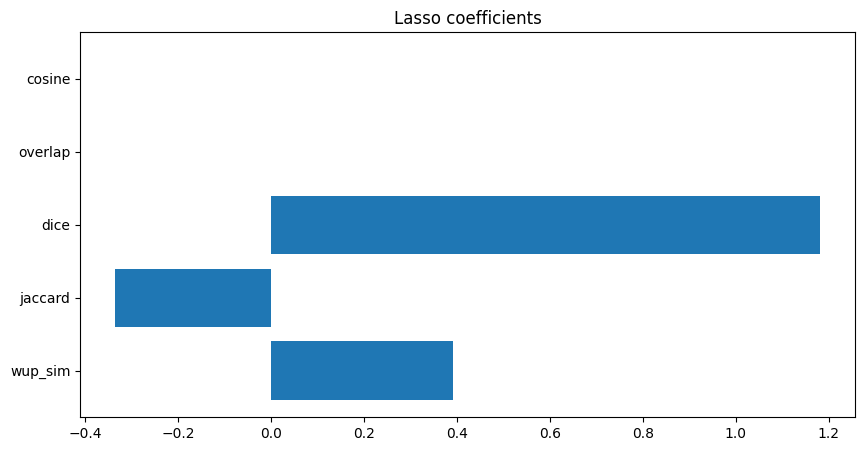

In [169]:
pipe.fit(X_sim_wup, y)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.barh(X_sim_wup.columns, pipe.named_steps['lasso'].coef_)
plt.title("Lasso coefficients")
plt.show()

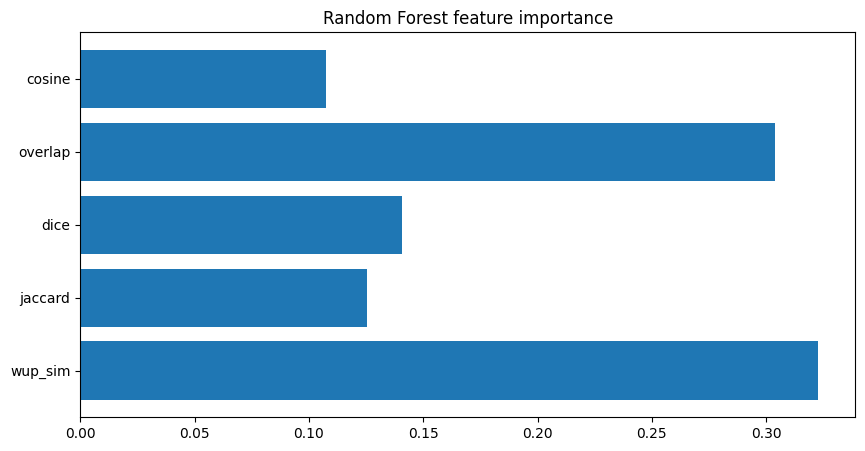

In [171]:
# get rf importance
rf.fit(X_sim_wup, y)
plt.figure(figsize=(10, 5))
plt.barh(X_sim_wup.columns, rf.feature_importances_)
plt.title("Random Forest feature importance")
plt.show()